# APPM 4720 Applied Deep Learning
## Progress Report 02 - Neural Network Block Modularization
## Sabrina Liu, September 21, 2021
The objectives of this progress report are:

1. to understand the classic VGG-Net and ResNet architectures in depth in terms of number of layers, trainable parameters, filter configurations and dimension reduction process. 

2. to establish a mechanism to build modularized blocks that can be integrated into any neural network as needed with configurable hyper-parameter selections, starting with the ones as recommended in the original papers. 

3. to start working with higher-resolution images such as (a subset of) the ImageNet classification dataset that can be fed into deeper neural networks and better understand the image batch load process in tensorflow/keras.

4. to run an experiment to compare both accuracy and efficiency performance between the above two architectures. 

Tutorials:
* How to Develop VGG, Inception and ResNet Modules from Scratch in Keras 
  * https://machinelearningmastery.com/how-to-implement-major-architecture-innovations-for-convolutional-neural-networks/

#### Mount Google Drive

In [48]:
# import images from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
%cd '/content/drive/MyDrive/ImageNet/2012/Classification'
!dir

/content/drive/MyDrive/ImageNet/2012/Classification
devkit	models	test  test10  train  train10  validation


#### Import Dependencies

In [50]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import add
from keras.layers import Flatten
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
from keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Nadam
from PIL import Image
import matplotlib.pyplot as plt
import pickle

#### Create VGG Block
A VGG block is part of a convolutional neural network that consists of several 3x3 (sometimes 1x1) convolutional filter layers followed by max pooling. Stacking VGG blocks together allows us to quickly build very deep neural networks that are extensions to the AlexNet. For hyper-parameter search, we care about below configurations when designing a VGG block:

* number of convolutional filters in each layer (width) - 64|128|256|512 (for VGG blocks the width of filters does not vary in block)
* layers of convolutional filters - 2|3|4
* use 1x1 convolution or not - True|False (if True, use 1x1 convolution for the last layer in block)


In [51]:
# create a function for adding a vgg block to the model in Keras
def vgg_block(layer_in, n_filters=64, n_conv=2, conv1=False):
    """ Function to add multiple convolutional layers.

    Keyword Arguments: 
    n_filters: number of channels to output in current block
    n_conv:    number of convolutional layers to add in current block
    conv1:     if True, use 1x1 convolution for the last layer in block

    Returns: output values processed by the VGG block
    """

    # add convolutional layers
    for i in range(n_conv):
        layer_in = Conv2D(n_filters, 
                          kernel_size=(1,1) if conv1 and (i == n_conv - 1) 
                                            else (3,3), 
                          padding='same', 
                          activation='relu',
                          kernel_initializer='he_normal')(layer_in)
    
    # add max pooling layer
    layer_out = MaxPooling2D(pool_size=(2,2))(layer_in)
    return layer_out

#### Inspect Block Architecture
For very deep neural networks with predefined blocks, it's both challenging and redundant to visualize the entire network architecture. But it is valuable to inspect the architecture inside the block to understand the operations and make sure that it is built correctly. Below we create a small dummy neural network with the block embedded in it to visualize the block architecture. 

In [52]:
# create a function inspect the architecture of modularized block with default hyper-parameters
def inspect_block(block_module, input_shape=(224, 224, 3), **kwargs):

    # reset layer name index
    K.clear_session()

    # define model input dimensions
    x = Input(shape=input_shape)
    
    # add block module with default hyper-parameters
    z = block_module(x, **kwargs)
    
    # create model to the scope of the block
    model = Model(inputs=x, outputs=z, name=block_module.__name__)
    
    # inspect block parameters
    display(model.summary())
    
    # inspect block architecture
    module_name = f"./models/{block_module.__name__}{str(kwargs)}.png"
    display(plot_model(model, show_shapes=True, to_file=module_name))

    return

#### Simple VGG Block
Let's check out a simple VGG block with 2 convolutional layers, each with 64 filters with 3x3 kernels. 
* The input dimensions are 224(H)x224(W)x 3(C)
* The first 3x3 convolutional layer re-dimensionalized the channel size into 64 channels with (3x3x3+1)x64 = 1792 parameters.
* We always need to add 1 to the left side of matrix multiplication (input dimensions) for biases. 
* The second 3x3 convolutional layer kept the channel width with (3x3x64+1)x64 = 36928 parameters. 
* The max pooling layer does not involve parameters, but reduced the spatial dimensions into 112x112 with pool size 2 (and stride size default to be the same with pool size). 


Model: "vgg_block"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
Total params: 38,720
Trainable params: 38,720
Non-trainable params: 0
_________________________________________________________________


None

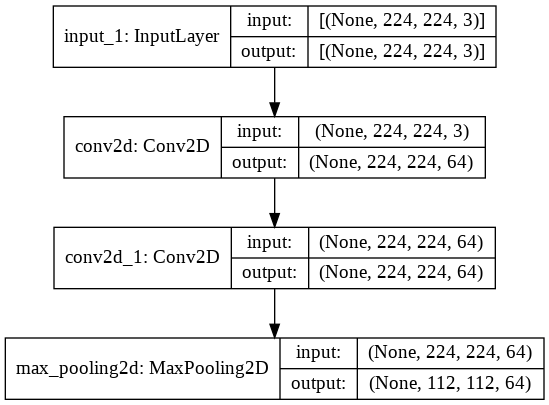

In [53]:
inspect_block(vgg_block, n_filters=64, n_conv=2)

#### VGG Block with 1x1 Convolution
Let's check out a different VGG block, with 3 convolutional layers, each with 512 filters, the first two using 3x3 kernels and the last using 1x1. 
* The input dimensions are still 224(H)x224(W)x 3(C)
* The first 3x3 convolutional layer re-dimensionalized the channel size into 512 channels with (3x3x3+1)x512 = 14336 parameters.
* The second 3x3 convolutional layer kept the channel dimension with (3x3x512+1)x512 = 2359808 parameters. 
* The third 1x1 convolutional layer kept the channel dimension but with much fewer parameters (1x1x512+1)x512 = 262656. 
* Again, the max pooling layer reduced the spatial dimensions by half into 112x112. 
* Our VGG block seems to be designed properly. 

Model: "vgg_block"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 512)     14336     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 512)     2359808   
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 512)     262656    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 512)     0         
Total params: 2,636,800
Trainable params: 2,636,800
Non-trainable params: 0
_________________________________________________________________


None

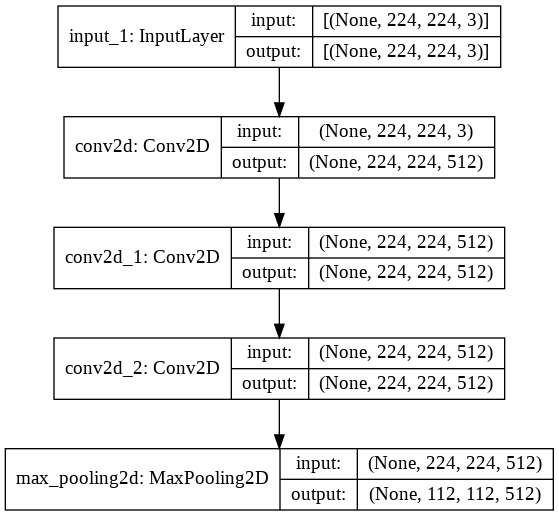

In [54]:
inspect_block(vgg_block, n_filters=512, n_conv=3, conv1=True)

#### Build VGG Networks
The goal here is to have a framework to recreate the configurations used in the original paper [https://arxiv.org/abs/1409.1556](https://arxiv.org/abs/1409.1556) when VGGNet was first introduced. Due to time limitation and for simplicity we are leaving out the Local Response Normalization (LRN) and Data Augmentation procedures in the paper and focus on the architecture itself. 
* We aim to recreate the A/B/C/D/E configurations according to below configuration table. 
* When referring to the number of layers, only layers with trainable parameters such as convolutional layers and dense layers are counted. (e.g. in configuration B, there are a total of 10 convolutional layers in 5 different VGG blocks and 3 fully connected  (dense) layers, therefore known as VGG-13. 

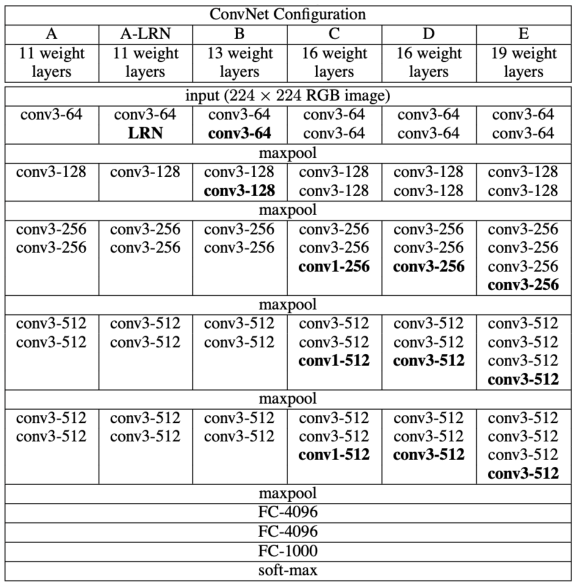

In [55]:
Image.open('./models/VGGNet_Config_Table.PNG')

In [56]:
def build_vggnet(input_shape=(224, 224, 3), n_classes=1000, config='A'):
  
    config_lookup = {
        'A': {'layers': 11, 
              'blocks': [(64, 1, False), (128, 1, False), (256, 2, False), 
                         (512, 2, False), (512, 2, False)]},
        'B': {'layers': 13,
              'blocks': [(64, 2, False), (128, 2, False), (256, 2, False), 
                         (512, 2, False), (512, 2, False)]},
        'C': {'layers': 16,
              'blocks': [(64, 2, False), (128, 2, False), (256, 3, True), 
                         (512, 3, True), (512, 3, True)]},
        'D': {'layers': 16,
              'blocks': [(64, 2, False), (128, 2, False), (256, 3, False), 
                         (512, 3, False), (512, 3, False)]},
        'E': {'layers': 19,
              'blocks': [(64, 2, False), (128, 2, False), (256, 4, False), 
                         (512, 4, False), (512, 4, False)]}
    }

    # initiate hyper-parameters
    hyper_params = config_lookup[config]
    depth = hyper_params['layers']
    blocks = hyper_params['blocks']

    # reset layer name index
    K.clear_session()

    # define model input dimensions
    x = Input(shape=input_shape)
    
    # add the VGG blocks   
    z = x
    for n_filters, n_conv, conv1 in blocks:
        z = vgg_block(z, n_filters=n_filters, n_conv=n_conv, conv1=conv1)
    
    # wrap up with dense layers and softmax
    z = Flatten()(z)
    z = Dense(units=4096, activation='relu')(z)
    z = Dense(units=4096, activation='relu')(z)
    z = Dense(units=n_classes, activation='softmax')(z)

    # create model
    model = Model(inputs=x, outputs=z, name=f'VGGNet-{depth}')
    return model

#### Check Out VGG-19

In [57]:
VGG19 = build_vggnet(config='E')
VGG19.summary()

Model: "VGGNet-19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0 

#### Create Residual Blocks
It has been observed that when neural networks gets deeper, the performance does not necessarily improve accordingly due to vanishing gradient. Residual learning is designed to bypass certain weight layers when necessary by adding a shortcut from the previous layer to the next step. Simply put, we create an identity block that preserves the input value of each residual block and add it to the convolutional layer outputs. When the channel dimensions do not match, we will use 1x1 convolution in the identity block to accommodate the concatenation operation. For hyper-parameter search, we care about below configurations when designing a residual block based on the original documentation:

* number of convolutional filters in each layer
* layers of convolutional filters
* whether to reduce spatial dimension by half in the beginning
* whether to use 1x1 convolution
* whether to increase the number of filters (multiply by 4) in the end

In [58]:
def residual_block(x, n_filters=64, n_conv=2, 
                   reduce_dim=False, conv1=False, mult4=False):
    """ Function to add identity block to multiple convolutional layer output.
    
    Keyword Arguments: 
    n_filters:  number of channels to output in current block
    n_conv:     number of convolutional layers to add in current block
    reduce_dim: if True, reduce the input dimension by half with stride 2
    conv1:      if True, use 1x1 convolution for first and last layer in block
    mult4:      if True, n_filters times 4 in the last layer in block

    Returns: output values processed by the residual block
    """

    id_block = x

	  # check if the number of filters needs to be increase
    # default format is to assume channel size comes last
    if (x.shape[-1] != n_filters) or mult4:
        id_block = Conv2D(filters=n_filters * 4 if mult4 
                                                else n_filters, 
                          kernel_size=(1,1), 
                          strides=2 if reduce_dim else 1,
                          padding='same', 
                          activation='relu', 
                          kernel_initializer='he_normal')(x)

    for i in range(n_conv):
        x = Conv2D(filters=n_filters * 4 if mult4 and (i == n_conv -1 ) 
                                         else n_filters, 
                   kernel_size=(1,1) if conv1 and (i != 1) 
                                     else (3,3), 
                   strides=2 if (i==0) and reduce_dim 
                             else 1,
                   padding='same',
                   activation='linear' if i == (n_conv - 1) 
                                       else 'relu', 
                   kernel_initializer='he_normal')(x)

    # add filters, assumes filters/channels last
    layer_out = add([x, id_block])
    
    # activation function
    layer_out = Activation('relu')(layer_out)
    
    return layer_out

#### Simple Residual Block
Let's check out a simple residual block with 2 convolutional layers, each with 64 filters with 3x3 kernels. 
* The input dimensions are 224(H)x224(W)x 3(C)
* The two 3x3 convolutional layers respectively has 1792 and 36928 parameters like the VGG net.
* Because the input layer has 3 channels, 1x1 convolution is used in the identity block, which has (1x1x3+1)x64 = 256 parameters. 

Model: "residual_block"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 224, 224, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 256         input_1[0][0]                    
_____________________________________________________________________________________

None

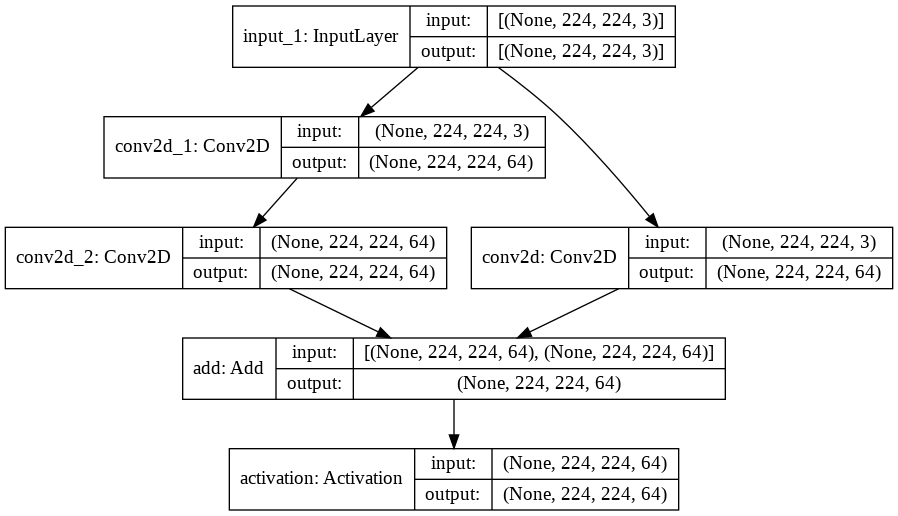

In [59]:
inspect_block(residual_block, n_filters=64, n_conv=2)

#### Residual Block with 1x1 Convolution
Now take a look at a residual block with 1x1 convolution and dimension increase as used in the original paper. 
* The first convolutional layer is 1x1 which outputs 64 channels with (1x1x3+1)x64 = 256 parameters. 
* The second convolution layer is 3x3 which outputs 64 channels with (3x3x64+1)x64 = 36928 parameters.
* The third convolutional layer is 1x1 which outputs 64x4 = 256 channels with (1x1x64+1)x256 = 16640 parameters. 
* The very last convolutional layer is the 1x1 in the identity block with (1x1x3+1)x 256 = 1024 parameters. 
* It appears that the residual block works as intended. 

Model: "residual_block"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 256         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 224, 224, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 224, 224, 256 16640       conv2d_2[0][0]                   
_____________________________________________________________________________________

None

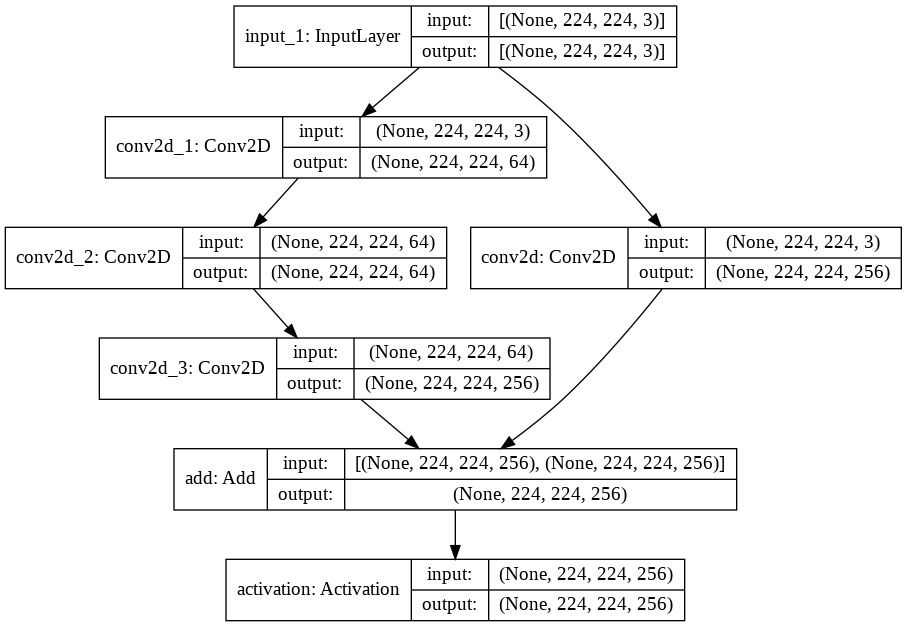

In [60]:
inspect_block(residual_block, n_filters=64, n_conv=3, conv1=True, mult4=True)

#### Build Residual Networks
Below shows the configuration table of the original ResNet as used in the paper. [https://ieeexplore.ieee.org/document/7780459](https://ieeexplore.ieee.org/document/7780459)

* The residual blocks does not use max pooling at the end of each block, but does use spatial dimension reduction with stride 2 at the beginning of each block when the number of filters increase to 128. 
* The residual networks provides configurations of very deep neural networks, combining repead residual blocks together. Again, only counting the layers with trainable parameters, the VGG-Net goes up to 19 layers, and the ResNet started at 18 layers. 
* All configurations of the residual networks reduce the spatial dimension to 7x7 before global average pooling instead of linear mapping in constrast to the VGG map. 

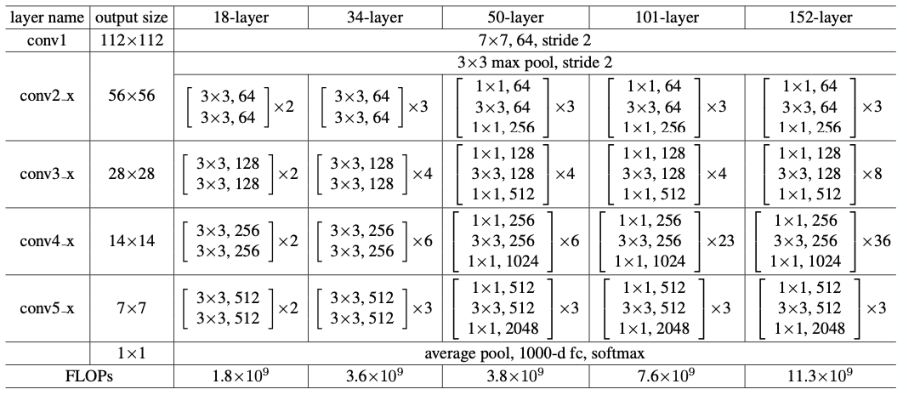

In [61]:
Image.open('./models/ResNet_Config_Table.PNG')

In [62]:
def build_resnet(input_shape=(224, 224, 3), n_classes=1000, config='A'):

    config_lookup = {
        'A': {'layers': 18, 
              'blocks': [(64, 2, False, False, 2), (128, 2, False, False, 2), 
                         (256, 2, False, False, 2), (512, 2, False, False, 2)]},
        'B': {'layers': 34,
              'blocks': [(64, 2, False, False, 3), (128, 2, False, False, 4), 
                         (256, 2, False, False, 6), (512, 2, False, False, 3)]},
        'C': {'layers': 50,
              'blocks': [(64, 3, True, True, 3), (128, 3, True, True, 4), 
                         (256, 3, True, True, 6), (512, 3, True, True, 3)]},
        'D': {'layers': 101,
              'blocks': [(64, 3, True, True, 3), (128, 3, True, True, 4), 
                         (256, 3, True, True, 23), (512, 3, True, True, 3)]},
        'E': {'layers': 152,
              'blocks': [(64, 3, True, True, 3), (128, 3, True, True, 8), 
                         (256, 3, True, True, 36), (512, 3, True, True, 3)]}
    }

    # initiate hyper-parameters
    hyper_params = config_lookup[config]
    depth = hyper_params['layers']
    blocks = hyper_params['blocks']

    # reset layer name index
    K.clear_session()

    # define model input dimensions
    x = Input(shape=input_shape)

    # add the initial convolutional layer and max pooling layer
    z = Conv2D(filters=64, 
              kernel_size=(7,7), 
              strides=2, 
              padding='same', 
              kernel_initializer='he_normal')(x)

    z = MaxPooling2D(pool_size=(2,2), padding='same')(z)

    # add block modules according to configuration table
    for n_filters, n_conv, conv1, mult4, n_blocks in blocks:
        for b in range(n_blocks):
            z = residual_block(z, n_filters=n_filters, n_conv=n_conv, 
                          conv1=conv1, mult4=mult4,
                          reduce_dim=((b == 0) and n_filters != 64))

    # wrap up with average pooling, dense layer and softmax
    z = GlobalAveragePooling2D()(z)
    z = Flatten()(z)
    z = Dense(units=n_classes)(z)
    z = Activation('softmax')(z)

    # create model
    model = Model(inputs=x, outputs=z, name=f'ResNet-{depth}')
    return model

In [63]:
ResNet18 = build_resnet(config='A')
ResNet18.summary()

Model: "ResNet-18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 56, 56, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 56, 56, 64)   36928       max_pooling2d[0][0]              
__________________________________________________________________________________________

#### Compare Number of Parameters of VGG-Net and ResNet Configurations

Surprisingly, the ResNet architecture uses a lot fewer parameters than the VGG-Net, mainly due to the elimination of the large dense layers (4096 units each) in the end using global average pooling. 

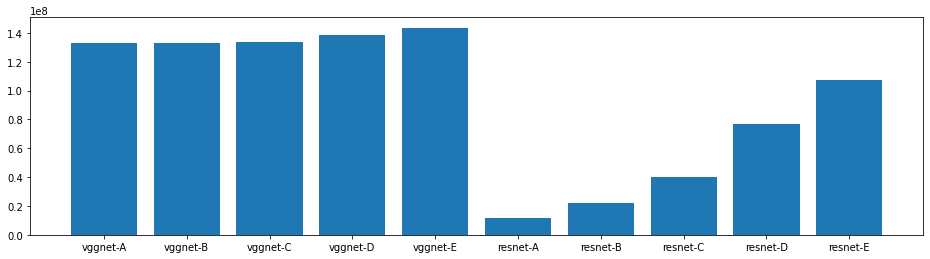

In [64]:
count_params = {}

for net in [build_vggnet, build_resnet]:
    for opt in ['A', 'B', 'C', 'D', 'E']:
        name = f"{net.__name__.strip('build_')}-{opt}"
        model = net(config=opt)
        count_params[name] = model.count_params()

plt.figure(figsize=(16,4))
_ = plt.bar(count_params.keys(), count_params.values())

#### Import ImageNet Dataset
We will use ImageNet 2012 dataset classification to test the performance of neural networks. Due to time limitation, 10 categories (all animals) out of the total 1000 categories were separated out and saved in ```\train10``` directory. Additionally, 100 images are taken out of each category for testing and saved in ```\test10``` directory. Below provides a quick preview of some images from each category. 

In [65]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf

In [66]:
os.listdir('./train10')

['n01443537',
 'n01484850',
 'n01537544',
 'n01644373',
 'n01682714',
 'n01735189',
 'n01980166',
 'n02074367',
 'n02096585',
 'n02169497']

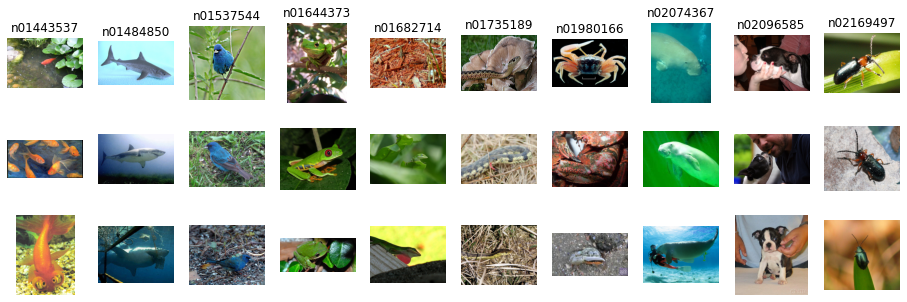

In [67]:
image_dir = './train10'
N_CLASSES = 10
N_SAMPLES = 3

fig, axes = plt.subplots(N_SAMPLES, N_CLASSES, figsize=(16, 5))

c = 0
for category in os.listdir(image_dir):
    r = 0
    for sample in os.listdir(os.path.join(image_dir, category))[:N_SAMPLES]:
        img = np.array(Image.open(os.path.join(image_dir, category, sample)))
        axes[0, c].set(title=category)
        axes[r, c].imshow(img)
        axes[r, c].axis('off')
        r += 1
    c += 1
        

In [81]:
%%time

BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

from functools import partial
load_data = partial(
    tf.keras.preprocessing.image_dataset_from_directory,
    directory='./train10',
    label_mode='categorical',  # read label as one-hot vector
    shuffle=True, seed=10,     # shuffle the data points
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    validation_split=.2,       # reserve 20% for validation
    crop_to_aspect_ratio=True  # preserve aspect ratio
)

ds_train = load_data(subset='training')
ds_valid = load_data(subset='validation')

ds_score = tf.keras.preprocessing.image_dataset_from_directory(
    directory='./test10',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    crop_to_aspect_ratio=True
)

Found 12000 files belonging to 10 classes.
Using 9600 files for training.
Found 12000 files belonging to 10 classes.
Using 2400 files for validation.
Found 1000 files belonging to 10 classes.
CPU times: user 1.44 s, sys: 777 ms, total: 2.21 s
Wall time: 1.52 s


In [69]:
for image_batch, labels_batch in ds_train:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32, 10)


In [70]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Tue Sep 21 19:50:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    40W / 300W |  15505MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### VGG-19 Versus ResNet-18

Due to time and resources limitation, we won't be able to finish training all the above listed configurations for VGG and ResNet. Instead, we choose VGG-19 and ResNet-18 which have similar layers of trainable parameters and observe their performance. Note that ResNet-18 uses a lot fewer paramters than VGG-19. 

In [71]:
%%time
N_EPOCHS = 100
N_WORKERS = 1000
N_CLASSES = len(ds_train.class_names)

VggNet19 = build_vggnet(config='E', n_classes=N_CLASSES)
ResNet18 = build_resnet(config='A', n_classes=N_CLASSES)

model_history = {}

for model in [VggNet19, ResNet18]:

    model_name = model.__dict__['_name']
    print(f"\nTraining on {model_name}...\n")

    # choose adaptive learning rate with momentum for optimization
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy', 
        metrics=['accuracy']
    )

    history = model.fit(
        ds_train, 
        validation_data=ds_valid,
        batch_size=BATCH_SIZE * N_WORKERS, 
        epochs=N_EPOCHS, 
        verbose=2,
        workers=N_WORKERS, 
        use_multiprocessing=True
    )
    
    model_history[model_name] = history.history

    model_file = f"./models/{model_name}.h5"
    model.save(model_file)


Training on VGGNet-19...

Epoch 1/100
300/300 - 50s - loss: 5214.8940 - accuracy: 0.1150 - val_loss: 2.2877 - val_accuracy: 0.1354
Epoch 2/100
300/300 - 49s - loss: 2.1743 - accuracy: 0.1694 - val_loss: 1.9982 - val_accuracy: 0.2221
Epoch 3/100
300/300 - 49s - loss: 2.0818 - accuracy: 0.2138 - val_loss: 1.9601 - val_accuracy: 0.2271
Epoch 4/100
300/300 - 49s - loss: 1.7689 - accuracy: 0.3300 - val_loss: 1.6543 - val_accuracy: 0.3804
Epoch 5/100
300/300 - 49s - loss: 1.5935 - accuracy: 0.3995 - val_loss: 1.5329 - val_accuracy: 0.4283
Epoch 6/100
300/300 - 49s - loss: 1.4954 - accuracy: 0.4478 - val_loss: 1.4867 - val_accuracy: 0.4483
Epoch 7/100
300/300 - 49s - loss: 1.4008 - accuracy: 0.4868 - val_loss: 1.5485 - val_accuracy: 0.4412
Epoch 8/100
300/300 - 49s - loss: 1.3561 - accuracy: 0.4998 - val_loss: 1.5235 - val_accuracy: 0.4325
Epoch 9/100
300/300 - 49s - loss: 1.2999 - accuracy: 0.5193 - val_loss: 1.3614 - val_accuracy: 0.5154
Epoch 10/100
300/300 - 49s - loss: 1.1999 - accuracy

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


CPU times: user 4h 1min 53s, sys: 19min 26s, total: 4h 21min 19s
Wall time: 1h 45min 36s


In [72]:
# when finish, write the model history as a binary file
with open('./models/model_history.pkl', 'wb') as pickle_file:
    pickle.dump(model_history, pickle_file)

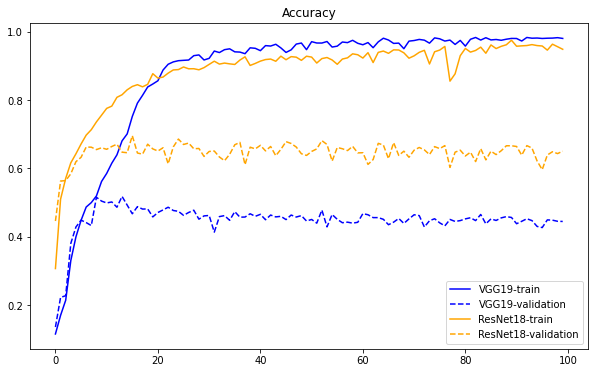

In [85]:
plt.figure(figsize=(10,6))

_ = plt.plot(model_history['VGGNet-19']['accuracy'], color='blue', label='VGG19-train')
_ = plt.plot(model_history['VGGNet-19']['val_accuracy'], color='blue', linestyle='--', label='VGG19-validation')

_ = plt.plot(model_history['ResNet-18']['accuracy'], color='orange', label='ResNet18-train')
_ = plt.plot(model_history['ResNet-18']['val_accuracy'], color='orange', linestyle='--', label='ResNet18-validation')

plt.title('Accuracy')
plt.legend()
plt.show()

#### Evaluate Performance
It can be observed from above history that even though both VGG-19 and ResNet-18 had similar training accuracy up to 100 epochs, ResNet-18 yielded much higher validation accuracy, which was also trained much faster with way fewer parameters. Since ResNet-18 was the last model trained, we can directly evaluate with the test dataset below:

In [82]:
model.evaluate(ds_score)

32/32 [==============================] - 1s 32ms/step - loss: 2.0264 - accuracy: 0.6840


[2.0263993740081787, 0.6840000152587891]